### Important note


The first step needed is to install Poppler in order to covert pdf files to sets of images. This can be done by downloading it from the following link:   https://blog.alivate.com.au/poppler-windows/

^ download the latest binary (I used poppler-0.68.0_x86)

Once this zip file is downloaded you will need to unzip it and save it somewhere on your computer. Then do the following steps:
1) Add the Poppler directory to your system PATH environment variable:

    a) Open the Start menu and search for "Edit the system environment variables"
    
    b) Click on the "Environment Variables" button
    
    c) Under "System Variables", scroll down and find the "Path" variable and click "Edit"
    
    d) Click "New" and enter the full path to the directory where you extracted the Poppler binaries (e.g., C:\poppler-21.11.0\bin). For me it was (C:\Users\Lhaye\OneDrive\Documents\poppler-0.68.0\bin)
    
    e) Click "OK" on all windows to close them and apply the changes
    
2) To check that Poppler is installed properly open command prompt and run the command "pdfinfo" in whatever location that you downloaded the unzipped file to. If it worked, you should see a bunch of information about the tool and its usage.

^ these are the instructions for windows but it may be different for other systems

In [ ]:
def Routine():
    # Import the necessary libraries
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import math
    from pdf2image import convert_from_path
    import os
    import tensorflow as tf
    from tensorflow.keras import regularizers
    
    def convert_to_binaryRGBA(matrix):
        return (np.sum(matrix, axis=2) > 0).astype(int)

    def convert_to_binaryRGB(matrix):
        return (np.sum(matrix, axis=2) < 200*3).astype(int) #150 before

    def Boarder_Indexes(pixel_array):

            #top down check
            i=0
            StartIndex = 0
            Color_Check = 0
            while Color_Check == 0:
                Color_Check = np.sum(pixel_array[i])

                if Color_Check>0:
                    StartIndex = i
                i+=1

            #bottom up check
            i=len(pixel_array)-1
            EndIndex = 0
            Color_Check = 0
            while Color_Check == 0:
                Color_Check = np.sum(pixel_array[i])

                if Color_Check >0:
                    EndIndex = i
                i-=1

            return(StartIndex,EndIndex)

    def consec(indexes):
        #find consecutive groupings
        consecutive = []

        # create a sublist to store each set of consecutive numbers
        sublist = [indexes[0]]

        for i in range(1, len(indexes)):
            if indexes[i] == indexes[i-1] + 1:
                sublist.append(indexes[i])
            else:
                #if its not consecutive append the sublist to main and reset the sublist
                consecutive.append(sublist)
                sublist = [indexes[i]]

         # add last sublist
        consecutive.append(sublist)
        return consecutive

    def LR_Letters(Line): #<- pass in sentence data
        Line = Line.T
        RowSum = Line.sum(axis=1)

        #copy same process as above

        IndexRange = [*range(0,len(RowSum),1)]
        #append the IndexRange to the Row Sum to find the index of each row
        Indexed_list = [(IndexRange[i], RowSum[i]) for i in range(0, len(RowSum))]

        #only grab tuples without 0 in second position - not blank
        Non_Blank_Tuples = [tup for tup in Indexed_list if tup[1]!=0 ]
        #now we have the row index for rows in the pdf that have words

        #now we can retrieve the index location of only the non blank rows
        index = []
        for t in Non_Blank_Tuples:
            ind,val = t
            index.append(ind)    
        LetterRows = consec(index) 

        #for seperating letters
        Avg_space_between_scentences = []
        n=0
        for i in range(0,len(LetterRows)-1):
            Space = min(LetterRows[n+1]) - max(LetterRows[n]) 
            Avg_space_between_scentences.append(Space)                    
            n+=1

        Avg_Space_Copy = Avg_space_between_scentences.copy()  

        #for num in Avg_space_between_scentences:
            #if num > np.mean(Avg_space_between_scentences)+(np.std(Avg_space_between_scentences)*2):
                #Avg_space_between_scentences.remove(num)
        i=0
        Adjustments = []
        for n in Avg_Space_Copy:
            if n < np.mean(Avg_space_between_scentences) - (np.std(Avg_space_between_scentences)*4.95): #GOOD AT 4.95
                Adjustments.append(i)
            i+=1
        c = 0
        for Adjustment in Adjustments:
            lista = list(range(min(LetterRows[Adjustment-c]), max(LetterRows[Adjustment+1-c]), 1))

            del LetterRows[Adjustments[c]:Adjustments[c]+2]
            LetterRows.insert(Adjustments[c],lista)
            c+=1  

        Letters = []
        i = 0
        for L in range(len(LetterRows)):
            INDVLetter = Line[LetterRows[i]].T

            #Find top and bottom border for each letter and refit the letter
            Top,Bottom = Boarder_Indexes(INDVLetter)
            INDVLetter = INDVLetter[Top:Bottom]

            Letters.append(INDVLetter)
            i+=1

        return Letters #returns a list of matrices of exactly fitted letters

    PDF_Data = r'C:\Users\Lhaye\Python Projects\Python_Data\Copy of Self made dataset.pdf'
    Save_DIR = r'C:\Users\Lhaye\Python Projects\Python_Data\SelfMade_Copy'

    #PDF_Data = r'C:\Users\Lhaye\Python Projects\Python_Data\Self made dataset.pdf'
    #Save_DIR = r'C:\Users\Lhaye\Python Projects\Python_Data\SelfMade_Data_JPGS'


    pages = convert_from_path(PDF_Data)
    for i in range(len(pages)):
        pages[i].save(Save_DIR+'\D_page'+str(i)+'.jpg',format='JPEG')

    Page_List = []
    for page in os.listdir(Save_DIR):
        PDF = Image.open(os.path.join(Save_DIR,page))
        PDFR = PDF.resize((2250,3300)) # was (2250,3300), (4500,6600)
        Array = np.asarray(PDFR)
        Binary = convert_to_binaryRGB(Array)
        Page_List.append(Binary)

    Each_Letter = []
    for Page in Page_List:

        #each time RowSum=0 it shows the space between each line
        RowSum = Page.sum(axis=1)

        IndexRange = [*range(0,len(RowSum),1)]
        #append the IndexRange to the Row Sum to find the index of each row
        Indexed_list = [(IndexRange[i], RowSum[i]) for i in range(0, len(RowSum))]

        #only grab tuples without 0 in second position - not blank
        Non_Blank_Tuples = [tup for tup in Indexed_list if tup[1]!=0 ]
        #now we have the row index for rows in the pdf that have words

        #now we can retrieve the index location of only the non blank rows
        indexes = []
        for t in Non_Blank_Tuples:
            ind,val = t
            indexes.append(ind)

        #standard deviations distances between scentences check - Scentences
        consecutives = consec(indexes)
        Avg_space_between_scentences = []
        n=0
        for i in range(0,len(consecutives)-1):
            Space = min(consecutives[n+1]) - max(consecutives[n]) 
            Avg_space_between_scentences.append(Space)                    
            n+=1

        Avg_Space_Copy = Avg_space_between_scentences.copy()  

        for num in Avg_space_between_scentences:
            if num > np.mean(Avg_space_between_scentences)+(np.std(Avg_space_between_scentences)*2): #GOOD AT 2
                Avg_space_between_scentences.remove(num)
        i=0
        Adjustments = []
        for n in Avg_Space_Copy:
            if n < np.mean(Avg_space_between_scentences) - (np.std(Avg_space_between_scentences)*2.25): #GOOD AT 2.25
                Adjustments.append(i)
            i+=1
        c = 0
        for Adjustment in Adjustments:
            lista = list(range(min(consecutives[Adjustment-c]), max(consecutives[Adjustment+1-c]), 1))

            del consecutives[Adjustments[c]:Adjustments[c]+2]
            consecutives.insert(Adjustments[c],lista)
            c+=1

        for S in consecutives: #consec (indexes) is a list of lists. each sub list is the consecutive indexes of a scentence on a page
            Scentence = Page[S]
            Letters = LR_Letters(Scentence)

            for L in Letters:
                Each_Letter.append(L)
    del Each_Letter[1676]
    del Each_Letter[5908]
    del Each_Letter[9956]
    del Each_Letter[14096]
    del Each_Letter[18144]
    del Each_Letter[18952]
    del Each_Letter[19044]
    del Each_Letter[19504]
    del Each_Letter[22192]
    del Each_Letter[26056]

    #Complicate the dataset
    rotation90= []
    rotation180=[]
    rotation270=[]

    for L in Each_Letter:
        rotation90.append(np.rot90(L,k=1))
        rotation180.append(np.rot90(L,k=2))
        rotation270.append(np.rot90(L,k=3))

    Each_Letter = Each_Letter+rotation90+rotation180+rotation270

    #find the max of each member of the shape tuples for all characters in the dataset
    MaxShape = []
    for Letter in Each_Letter:
        MaxShape.append(np.shape(Letter))
    MaxTrain = [max(i) for i in zip(*MaxShape)]  

    characters = '`1234567890=qwertyuiop[]\\asdfghjkl;’zxcvbnm,./~!@#$%^&*()_+QWERTYUIOP{}|ASDFGHJKL:ZXCVBNM<>?'
    clist = list(characters)
    Final_Characters = clist*294*4

    Adjusted_DF = pd.DataFrame(columns=["Final_Character", "Final", "Shape"])
    #n = 0
    for n in range(len(Each_Letter)):
        L = Each_Letter[n]
        try:
            E_Size = MaxShape[n]
            Diff = (MaxTrain[0]-E_Size[0],MaxTrain[1]-E_Size[1])

            height_add = Diff[0]
            width_add = Diff[1]

            #find adjustments to each side of the character to standardize the pixels shapes
            #round up for right and bottom if and odd number of pixel (add 1 more to those pixel amounts) - otherwise even distribution
            Top = math.floor(height_add/2)
            Bottom = math.ceil(height_add/2)
            Left = math.floor(width_add/2)
            Right = math.ceil(width_add/2)

            Zero_Right = np.zeros((len(L),Right))
            Zero_Left = np.zeros((len(L),Left))

            Step1 = np.c_[Zero_Left,L,Zero_Right]
            Zero_Top = np.zeros((len(Step1[0]),Top))
            Zero_Bottom = np.zeros((len(Step1[0]),Bottom))

            Final = np.r_[Zero_Top.transpose(),Step1,Zero_Bottom.transpose()].astype('uint8')

            Adjusted_DF.loc[n] = [Final_Characters[n], Final, np.shape(Final)]

        except:
            print(n)
            pass

    Data_Complete = pd.DataFrame(np.c_[Adjusted_DF['Final'],Adjusted_DF['Final_Character']])
    Train_Data = Data_Complete

    #testing dataset
    PDF_Data = r'C:\Users\Lhaye\Python Projects\Python_Data\Project PDF Example.pdf'

    from pdf2image import convert_from_path
    pages = convert_from_path(PDF_Data)
    for i in range(len(pages)):
        pages[i].save('T_page'+str(i)+'.jpg','JPEG')

    #open pdf
    PDF= Image.open('T_page0.jpg')

    #resize for better resolution
    PDF = PDF.resize((4500,6600))

    #convert each to pixel array
    PDF_Array = np.asarray(PDF)

    #convert each to binary array (0 or 1)
    Binary_PDF = convert_to_binaryRGB(PDF_Array)


    def LR_Letters(Line): #<- pass in sentence data
        Line = Line.T
        RowSum = Line.sum(axis=1)

        #copy same process as above
        IndexRange = [*range(0,len(RowSum),1)]
        #append the IndexRange to the Row Sum to find the index of each row
        Indexed_list = [(IndexRange[i], RowSum[i]) for i in range(0, len(RowSum))]

        #only grab tuples without 0 in second position - not blank
        Non_Blank_Tuples = [tup for tup in Indexed_list if tup[1]!=0 ]
        #now we have the row index for rows in the pdf that have words

        #now we can retrieve the index location of only the non blank rows
        index = []
        for t in Non_Blank_Tuples:
            ind,val = t
            index.append(ind)    
        LetterRows = consec(index)

        Letters = []
        i = 0
        for L in range(len(LetterRows)):
            INDVLetter = Line[LetterRows[i]].T

            #Find top and bottom border for each letter and refit the letter
            Top,Bottom = Boarder_Indexes(INDVLetter)
            INDVLetter = INDVLetter[Top:Bottom]

            Letters.append(INDVLetter)
            i+=1

        return Letters #returns a list of matrices of exactly fitted letters

    def consec(indexes):
        #find consecutive groupings
        consecutive = []

        # create a sublist to store each set of consecutive numbers
        sublist = [indexes[0]]

        for i in range(1, len(indexes)):
            if indexes[i] == indexes[i-1] + 1:
                sublist.append(indexes[i])
            else:
                #if its not consecutive append the sublist to main and reset the sublist
                consecutive.append(sublist)
                sublist = [indexes[i]]

         # add last sublist
        consecutive.append(sublist)
        return consecutive

    #____________Main Loop

    #
    Each_Letter = []

    #each time RowSum=0 it shows the space between each line
    RowSum = Binary_PDF.sum(axis=1)

    IndexRange = [*range(0,len(RowSum),1)]
    #append the IndexRange to the Row Sum to find the index of each row
    Indexed_list = [(IndexRange[i], RowSum[i]) for i in range(0, len(RowSum))]

    #only grab tuples without 0 in second position - not blank
    Non_Blank_Tuples = [tup for tup in Indexed_list if tup[1]!=0 ]
    #now we have the row index for rows in the pdf that have words

    #now we can retrieve the index location of only the non blank rows
    indexes = []
    for t in Non_Blank_Tuples:
        ind,val = t
        indexes.append(ind)

    for S in consec(indexes): #consec (indexes) is a list of lists. each sub list is the consecutive indexes of a scentence on a page
        Scentence = Binary_PDF[S]
        Letters = LR_Letters(Scentence)   

        for L in Letters:
            Each_Letter.append(L)

    characters = 'By lowering the reserve requirement, the central bank is aiming to increase capital allocation. A decrease to the reserve requirement increases total investable funds for the banks - allowing for a larger portion of total deposits to be invested back into the economy. Given that the banks will now be able to achieve higher returns (assuming the single period return to capital x is larger than return to fiat money n/z), the banks will be able to pay higher interest to clients. This can have secondary effects on the individual’s propensity to save. These secondary effects can be broken down into two categories based on the goal of the policy change. As the banks will now be able to pay higher interest on deposits, individuals will place a higher value on deposits than before. This may incentivize more deposits for each individual (they will deposit more funds to gain the additional interest). This can work as a good tool if the central bank determines that the economic issue is related to the supply of goods. Assuming that the main source of investment for banks is through capital which produce goods, funds in the economy will be moved in the direction of capital investment and good creation. If the central bank determines the economic issues are related to output, but also for the demand of this output, I believe they should also propose a temporary cap for interest growth. This will still allow banks to invest additional funds into capital, but individuals will be more willing to spend their funds instead of saving in the form of deposits. This way the economy could avoid any issues relating to an increased propensity to save.'
    clist = list(characters)
    No_Space_List = [c for c in clist if c != ' ']

    #find the max of each member of the shape tuples for all characters in the dataset
    MaxShape = []
    for Letter in Each_Letter:
        MaxShape.append(np.shape(Letter))
    Max = [max(i) for i in zip(*MaxShape)] 

    Adjusted_DF =pd.DataFrame()

    n = 0
    for L in Each_Letter:

        E_Size = MaxShape[n]
        Diff = (Max[0]-E_Size[0],Max[1]-E_Size[1])

        height_add = Diff[0]
        width_add = Diff[1]


        #find adjustments to each side of the character to standardize the pixels shapes
            #round up for right and bottom if and odd number of pixel (add 1 more to those pixel amounts) - otherwise even distribution
        Top = math.floor(height_add/2)
        Bottom = math.ceil(height_add/2)
        Left = math.floor(width_add/2)
        Right = math.ceil(width_add/2)



        Zero_Right = np.zeros((len(L),Right))
        Zero_Left = np.zeros((len(L),Left))

        Step1 = np.c_[Zero_Left,L,Zero_Right]

        Zero_Top = np.zeros((len(Step1[0]),Top))
        Zero_Bottom = np.zeros((len(Step1[0]),Bottom))

        Final = np.r_[Zero_Top.transpose(),Step1,Zero_Bottom.transpose()]

        Adjusted_DF[n] = [No_Space_List[n],Final,np.shape(Final)]

        n+=1

    Adjusted_DF = pd.DataFrame.transpose(Adjusted_DF)

    Comparable_DF=pd.DataFrame()
    n=0
    for member in Adjusted_DF[1]:
        # Create a plot with no axis
        fig, ax = plt.subplots()
        ax.imshow(member, cmap='binary', interpolation='nearest')
        ax.axis('off')

        # Save the figure without the axis
        plt.savefig('letterplot.jpg', bbox_inches='tight', pad_inches=0)
        plt.close()

        #^load in this graphic with a set pixel arrangment
        Len_wid = MaxTrain
        LetterImage = Image.open('letterplot.jpg')
        new = LetterImage.resize((Len_wid[1],Len_wid[0]))
        newPixelArray = np.asarray(new)
        newPixelArray = convert_to_binaryRGB(newPixelArray)
        Comparable_DF[n] = [No_Space_List[n],newPixelArray,np.shape(newPixelArray)]
        n+=1
    Comparable_DF = Comparable_DF.T    

    #SAME AS ABOVE BUT WITHOUT FLATTEN ROUTINE
    Data_Complete = pd.DataFrame(np.c_[Comparable_DF[1],Comparable_DF[0]])

    Test_Data = Data_Complete


    #Training the System initial
    #Create character dictionary
    characters = '`1234567890-=qwertyuiop[]\\asdfghjkl;’zxcvbnm,./~!@#$%^&*()_+QWERTYUIOP{}|ASDFGHJKL:ZXCVBNM<>?'
    clist = list(characters)

    IndexRange = [*range(0,len(clist),1)]
    Char_Dict = {}
    for key in clist:
        for value in IndexRange:
            Char_Dict[key] = value
            IndexRange.remove(value)
            break

    #need to convert alhpabetical lables to numerical for fitting
    Test_Data.replace({1: Char_Dict},inplace=True)
    Train_Data.replace({1: Char_Dict},inplace=True)

    #convert back to labels on bottom row arrangement
    Train_Data = Train_Data.T
    Test_Data = Test_Data.T

    #seperate between images and labels for both train and test
    TrainImagesF = Train_Data.iloc[0]
    TrainImagesF = np.array(TrainImagesF.T.values.tolist())
    TrainLabels = Train_Data.iloc[-1]
    TrainLabels = np.array(TrainLabels.values.tolist())

    TestImagesF = Test_Data.iloc[0]
    TestImagesF = np.array(TestImagesF.T.values.tolist())
    TestLabels = Test_Data.iloc[-1]
    TestLabels = np.array(TestLabels.values.tolist())
    
    return (TrainImagesF,TrainLabels,TestImagesF,TestLabels)

In [ ]:
Result = Routine()

In [ ]:
Result

In [ ]:
from joblib import dump
dump(Result,'Processing.joblib')

## Adjustments

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import regularizers


from joblib import load
Result = load('Processing.joblib')
TrainImagesF = Result[0]
TrainLabels = Result[1]
TestImagesF = Result[2]
TestLabels = Result[3]

C:\Users\Lhaye\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Lhaye\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Lhaye\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\Lhaye\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


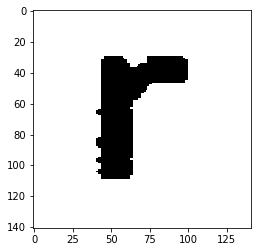

16


In [2]:
a=100
plt.imshow(TestImagesF[a],cmap='binary',interpolation='nearest')
plt.show()
print(TestLabels[a])

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(30, (30, 30), activation='relu', input_shape=(141,141,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(93, activation='softmax')
])

In [4]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [5]:
print(np.shape(TrainImagesF))
print(len(TrainImagesF))
print(len(TrainLabels))

(108192, 141, 141)
108192
108192


In [6]:
model.fit(TrainImagesF, TrainLabels, epochs=5)

Epoch 1/5
3381/3381 [==============================] - 5435s 2s/step - loss: 1.2025 - accuracy: 0.6703
Epoch 2/5
3381/3381 [==============================] - 5409s 2s/step - loss: 0.3750 - accuracy: 0.8776
Epoch 3/5
3381/3381 [==============================] - 5416s 2s/step - loss: 0.1805 - accuracy: 0.9382
Epoch 4/5
3381/3381 [==============================] - 5429s 2s/step - loss: 0.1086 - accuracy: 0.9635
Epoch 5/5
3381/3381 [==============================] - 5417s 2s/step - loss: 0.0701 - accuracy: 0.9763


In [7]:
test_loss, test_acc = model.evaluate(TestImagesF,  TestLabels, verbose=2)

print(test_acc)

43/43 - 5s - loss: 6.4954 - accuracy: 0.0000e+00 - 5s/epoch - 127ms/step
0.0


# Predictions

In [13]:
characters = '`1234567890-=qwertyuiop[]\\asdfghjkl;’zxcvbnm,./~!@#$%^&*()_+QWERTYUIOP{}|ASDFGHJKL:ZXCVBNM<>?'
clist = list(characters)

In [14]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [15]:
predictions = probability_model.predict(TestImagesF)

43/43 [==============================] - 5s 126ms/step


In [16]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(clist[predicted_label],
                                100*np.max(predictions_array),
                                clist[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(93))
  plt.yticks([])
  thisplot = plt.bar(range(93), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

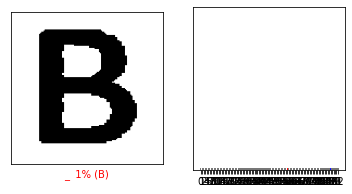

In [17]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], TestLabels, TestImagesF)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  TestLabels)
plt.show()

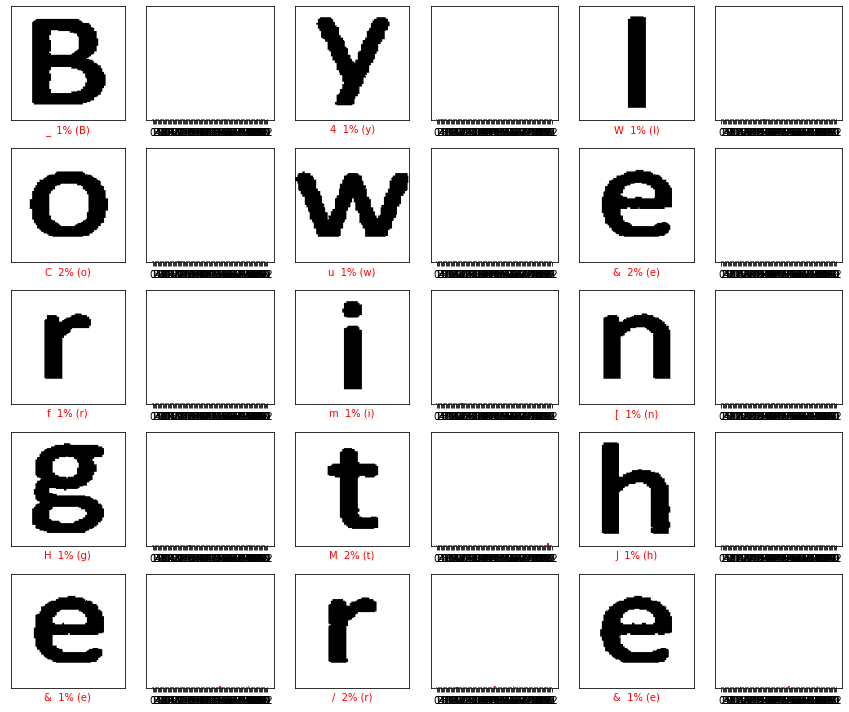

In [18]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], TestLabels, TestImagesF)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], TestLabels)
plt.tight_layout()
plt.show()